# <font  color = "#0093AF"> Short Examples

<a href="https://githubtocolab.com/alsinmr/SLEEPY_tutorial/blob/main/ColabNotebooks/Chapter1/Ch1_ShortExamples.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

The following notebook shows some simulations that can be done in just a few lines of code. These are intended to simply familiarize you with the basics of setting up SLEEPY simulations.

## Setup

In [0]:
# SETUP SLEEPY

In [2]:
import SLEEPY as sl
import numpy as np

## 1D Spectrum in Exchange
Two peaks, separated by 10 ppm, with a correlation time of exchange of 1 ms.

State-space reduction: 8->2


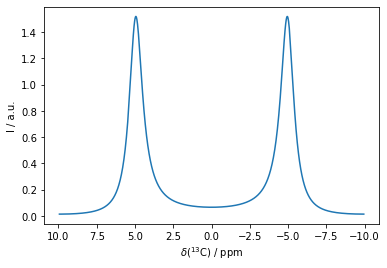

In [3]:
ex0=sl.ExpSys(600,Nucs='13C')
ex1=ex0.copy()
ex0.set_inter('CS',i=0,ppm=5)
ex1.set_inter('CS',i=0,ppm=-5)

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-3))
seq=L.Sequence(Dt=1/3000)  #1/(2*10 ppm*150 MHz)

rho=sl.Rho('13Cx','13Cp')
rho.DetProp(seq,n=4096)
_=rho.plot(FT=True,axis='ppm')

## $T_1$ relaxation in solid-state NMR
$^{13}$C $T_1$ relaxation in solid-state NMR, due to a 30$^\circ$ reorientation of the H–C dipole coupling, occuring with a correlation time of 1 ns.

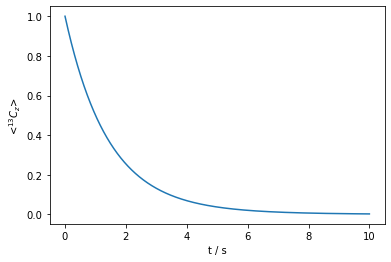

In [4]:
ex0=sl.ExpSys(600,Nucs=['13C','1H'],vr=10000,LF=True)  #T1 occurs only due to terms in the lab frame
ex1=ex0.copy()
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-9))
seq=L.Sequence() #Defaults to 1 rotor period

rho=sl.Rho('13Cz','13Cz')
rho.DetProp(seq,n=10000*10) #10 seconds
_=rho.plot(axis='s')

## $T_{1\rho}$ relaxation
$^{13}$C $T_{1\rho}$ relaxation in solid-state NMR, due to a 15$^\circ$ reorientation of the H–C dipole coupling, occuring with a correlation time of 100 ns.

State-space reduction: 32->16


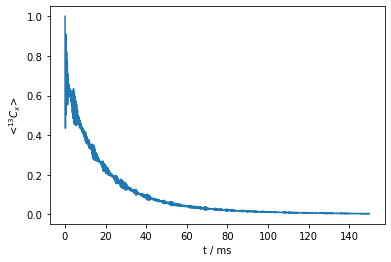

In [5]:
ex0=sl.ExpSys(600,Nucs=['13C','1H'],vr=10000)
ex1=ex0.copy()
ex0.set_inter('dipole',i0=0,i1=1,delta=44000)
ex1.set_inter('dipole',i0=0,i1=1,delta=44000,euler=[0,30*np.pi/180,0])

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-7))
seq=L.Sequence().add_channel('13C',v1=25000) #Defaults to 1 rotor period

rho=sl.Rho('13Cx','13Cx')
rho.DetProp(seq,n=1500) #100 ms
_=rho.plot()

## Chemical Exchange Saturation Transfer
CEST is useful when a system has a major and minor population, the minor being invisible in the spectrum. However, applying a saturating field to the minor population will still be effective in saturating the major population, so that we may sweep through a saturating field to find the minor population's resonance frequency.

In this simple example, we'll just monitor the total z-magnetization, although in the real experiment we would rather integrate the peak with high population (also possible in SLEEPY, but requires acquiring the full direct dimension).

Text(0.5, 0, '$\\nu_{off}$ / kHz')

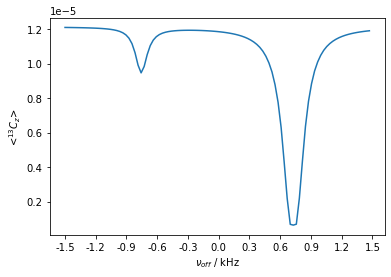

In [44]:
ex0=sl.ExpSys(600,Nucs='13C')
ex1=ex0.copy()
ex0.set_inter('CS',i=0,Hz=750)
ex1.set_inter('CS',i=0,Hz=-750)

L=sl.Liouvillian(ex0,ex1,kex=sl.Tools.twoSite_kex(tc=1e-1,p1=.95))  #5% population 2
L.add_relax('T1',i=0,T1=1)
L.add_relax('T2',i=0,T2=.1)
L.add_relax('recovery')
seq=L.Sequence(Dt=.5)  #1/(2*10 ppm*150 MHz)

rho=sl.Rho('13Cz','13Cz')
voff0=np.linspace(-1500,1500,101)

for voff in voff0:
    rho.reset()
    (seq.add_channel('13C',v1=50,voff=voff)*rho)()
ax=rho.plot()
ax.set_xticks(np.linspace(0,101,11))
ax.set_xticklabels(voff0[np.linspace(0,100,11).astype(int)]/1000)
ax.set_xlabel(r'$\nu_{off}$ / kHz')

## Contact shift
The contact shift comes from the hyperfine coupling between a fast-relaxing electron and a nucleus. While the fast relaxing electron averages the splitting away, the peak itself shifts due to polarization of the electron.

We'll run the simulation as a function of temperature, where lower temperatures yield a higher shift (and more signal). Note that realistically, we wouldn't expect the electron relaxation times to remain fixed with the varying temperature.

State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2
State-space reduction: 16->2


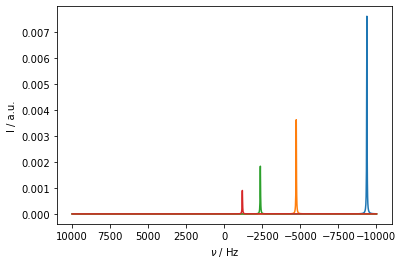

In [54]:
ax=None
ex=sl.ExpSys(600,Nucs=['13C','e']).set_inter('hyperfine',i0=0,i1=1,Axx=1e5,Ayy=1e5,Azz=1e5)
for T in [50,100,200,400]:
    ex.T_K=T
    L=ex.Liouvillian()
    L.add_relax('T1',i=1,T1=1e-9)
    L.add_relax('T2',i=1,T2=1e-10)
    L.add_relax('recovery')

    seq=L.Sequence(Dt=5e-5)

    rho=sl.Rho('13Cx','13Cp')
    ax=rho.DetProp(seq,n=2048).plot(FT=True,ax=ax)

## Spinning side-bands (one liner)
The last simulation is a little bit just for fun, but also to demonstrate some of the convenience of the SLEEPY simulation setup. We simulate $^{13}$C spinning sidebands resulting from chemical shift anisotropy. However, we set up the whole simulation in a single line of code and plot the result.

Compare to Herzfeld/Berger figure 2c.$^1$

[1] J. Herzfeld, A.E. Berger. *[J.Chem. Phys.](https://doi.org/10.1063/1.440136)* **1980**, 73, 6021-6030.

State-space reduction: 4->1
Prop: 20 steps per every 1 rotor period


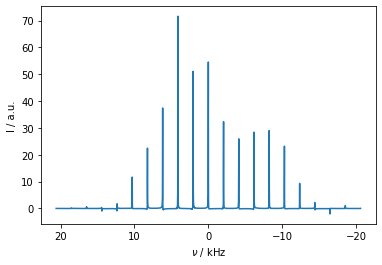

In [41]:
_=sl.Rho('31Px','31Pp').DetProp(
    sl.ExpSys(B0=6.9009,Nucs='31P',vr=2060).set_inter('CSA',i=0,delta=-104,eta=.56).\
    Liouvillian().Sequence(),
    n=4096,n_per_seq=20).plot(FT=True,axis='kHz',apodize=True)